<a href="https://colab.research.google.com/github/0-lingual/DBGAPS/blob/main/Black_Litterman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas yfinance schedule PyPortfolioOpt finance-datareader

In [ ]:
import FinanceDataReader as fdr
import pandas as pd
from datetime import datetime

# ETF 목록
etf_list = {
    'KOSPI': '069500',
    'KOSDAQ': '232080',
    'S&P500': '143850',
    'STOXX': '195930',
    'Nikkei': '241180',
    'CSI': '192090',

    'Gold': '132030',
    'WTI': '130680',
}

# 시작 날짜와 종료 날짜 설정
start_date = '2018-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

def fetch_etf_data(etf_dict, start, end):
    df_list = []
    for name, code in etf_dict.items():
        data = fdr.DataReader(code, start, end)
        data = data[['Close']]
        data.columns = [name]
        df_list.append(data)
    return pd.concat(df_list, axis=1)

# ETF 데이터 가져오기
etf_df = fetch_etf_data(etf_list, start_date, end_date)

# 데이터 저장
etf_df.to_csv('etf_df.csv')

print("ETF 데이터가 etf_df.csv 파일에 저장되었습니다.")



ETF 데이터가 etf_df.csv 파일에 저장되었습니다.


In [ ]:
etf_df

,KOSPI,KOSDAQ,S&P500,STOXX,Nikkei,CSI,Gold,WTI
Date,,,,,,,,
2018-01-02,28609,13994,31770,11485,11871,8309,9805,4410
2018-01-03,28730,14218,31995,11490,11922,8384,9835,4380
2018-01-04,28506,13825,32205,11590,12300,8384,9805,4505
2018-01-05,28892,14358,32350,11755,12355,8448,9870,4490
2018-01-08,29085,14753,32560,11820,12429,8452,9870,4470
...,...,...,...,...,...,...,...,...
2024-06-27,38320,13945,60400,17590,20670,8655,14265,4675
2024-06-28,38545,13945,60675,17565,20635,8590,14425,4745
2024-07-01,38620,14200,60445,17710,20710,8650,14420,4730


In [ ]:
etf_df.isnull().sum()

KOSPI     0
KOSDAQ    0
S&P500    0
STOXX     0
Nikkei    0
CSI       0
Gold      0
WTI       0
dtype: int64

In [ ]:
market_prices = etf_df.copy()
market_prices.head()

,KOSPI,KOSDAQ,S&P500,STOXX,Nikkei,CSI,Gold,WTI
Date,,,,,,,,
2018-01-02,28609,13994,31770,11485,11871,8309,9805,4410
2018-01-03,28730,14218,31995,11490,11922,8384,9835,4380
2018-01-04,28506,13825,32205,11590,12300,8384,9805,4505
2018-01-05,28892,14358,32350,11755,12355,8448,9870,4490
2018-01-08,29085,14753,32560,11820,12429,8452,9870,4470


In [ ]:
import pypfopt
pypfopt.__version__

'1.5.5'

In [ ]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(market_prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

KOSPI     1.251830
KOSDAQ    0.291082
S&P500    2.784953
STOXX     1.785853
Nikkei    2.877179
CSI       0.150179
Gold      2.387035
WTI       0.469803
dtype: float64

In [ ]:
# plotting.plot_covariance(S, plot_correlation=True);

In [ ]:
# market_prices.plot(figsize=(10,6));

KOSPI     0.155704
KOSDAQ    0.105553
S&P500    0.191336
STOXX     0.171734
Nikkei    0.199866
CSI      -0.039448
Gold      0.134558
WTI       0.165667
Name: 2024-07-03 00:00:00, dtype: float64

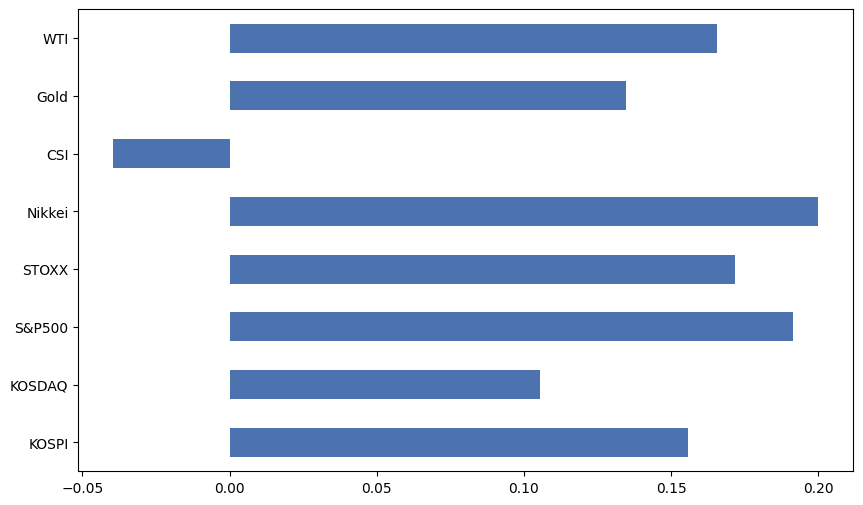

In [ ]:
from pypfopt import expected_returns

market_prior = expected_returns.ema_historical_return(etf_df)
market_prior.plot.barh(figsize=(10,6));
market_prior

View Returns

In [ ]:
#투자 매력도
# KOSPI     0.155704 1
# KOSDAQ    0.105553 1
# S&P500    0.191336 2
# STOXX     0.171734 3
# Nikkei    0.199866 1
# CSI      -0.039448 3
# Gold      0.134558 2
# WTI       0.165667 3
viewdict = {
    'KOSPI' : +0.3,
    'KOSDAQ': +0.1,

    'S&P500': +0.2,
    'STOXX' : -0.1,
    'Nikkei': +0.2,
    'CSI'   : -0.1,

    'Gold'  : -0.1,
    'WTI'   : -0.2,
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)


In [ ]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

KOSPI     0.162563
KOSDAQ    0.106813
S&P500    0.150487
STOXX     0.081260
Nikkei    0.181762
CSI      -0.074275
Gold      0.022050
WTI      -0.020487
dtype: float64

In [ ]:
rets_df = pd.DataFrame([market_prior, pd.Series(viewdict), ret_bl],
             index=["Prior", "Views", "Posterior"]).T
rets_df

,Prior,Views,Posterior
KOSPI,0.155704,0.3,0.162563
KOSDAQ,0.105553,0.1,0.106813
S&P500,0.191336,0.2,0.150487
STOXX,0.171734,-0.1,0.081260
Nikkei,0.199866,0.2,0.181762
CSI,-0.039448,-0.1,-0.074275
Gold,0.134558,-0.1,0.022050
WTI,0.165667,-0.2,-0.020487


Return Plot

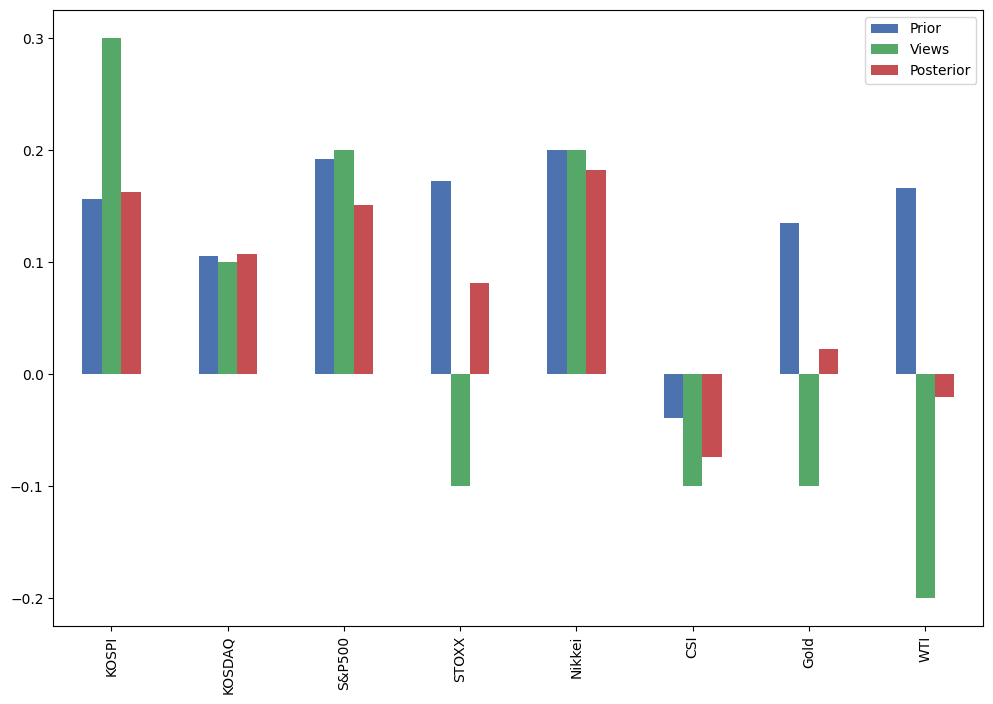

In [ ]:
rets_df.plot.bar(figsize=(12,8));

In [ ]:
sector_mapper = {
    'KOSPI': 'korea_stock',
    'KOSDAQ': 'korea_stock',

    'S&P500': 'stocks',
    'STOXX': 'stocks',
    'Nikkei': 'stocks',
    'CSI': 'stocks',

    'Gold': 'derives',
    'WTI': 'derives',

    }
sector_lower = {
        'korea_stock':0.2,
        'stocks':0.2,
        'derives':0.05,
    }

sector_upper = {
     'korea_stock':0.4,
     'stocks':0.4,
    #  'derives':0.1,
    }

In [ ]:
from pypfopt import EfficientFrontier, objective_functions
ef = EfficientFrontier(ret_bl, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_constraint(lambda x: x <= 0.2)
ef.max_sharpe()
weights = ef.clean_weights()
weights

ValueError: invalid literal for int() with base 10: 'Gold'

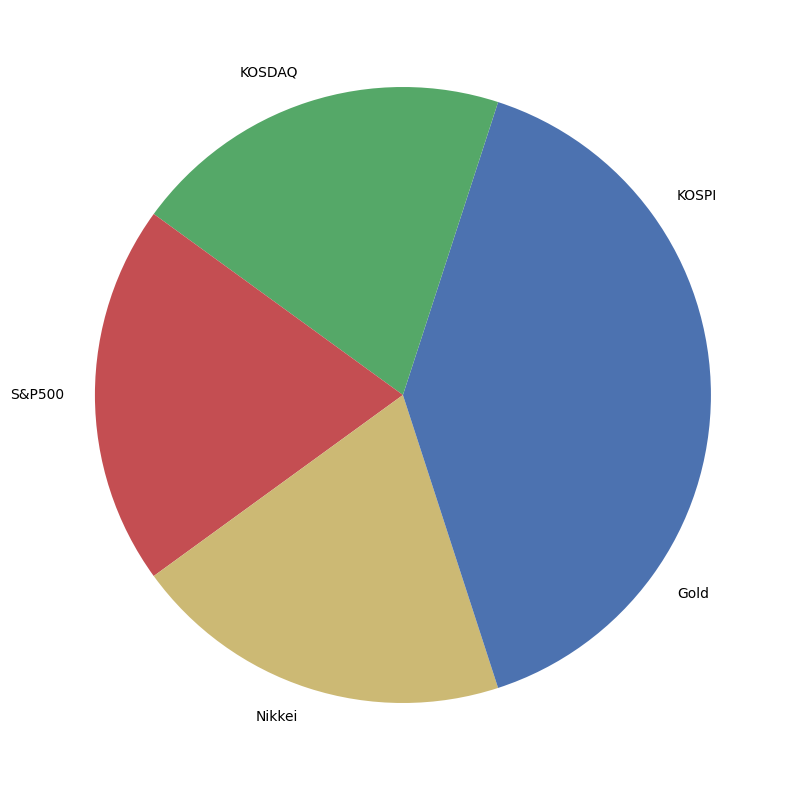

In [ ]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [ ]:
weights

OrderedDict([('KOSPI', 0.2),
             ('KOSDAQ', 0.2),
             ('S&P500', 0.2),
             ('STOXX', 0.0),
             ('Nikkei', 0.2),
             ('CSI', 0.0),
             ('Gold', 0.2),
             ('WTI', 0.0)])